In [2]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from fastai.imports import *
from fastai.structured import *
import multiprocessing as mp
from celluloid import Camera

/Users/girish/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [25]:
def trainandtest_split(data,train_per):
    shuffle=data.sample(frac=1).reset_index(drop=1)
    i=int(train_per*len(data)/100)
    return [shuffle[:i],shuffle[i:]]

def k_fold(data,k):
    shuffle=data.sample(frac=1).reset_index(drop=1)
    i=int(len(shuffle)/k)
    cvs=np.array([None]*k)
    for j in range(k):
        cvs[j]=shuffle[i*j:i*(j+1)]
    return cvs

#Classification---------------------------------------------------
def no_of_class(data):
    return np.sort(pd.unique(data[data.columns[-1]]))
    
def cls_data(data,noc):
    c=noc
    cls=np.array([0]*3)
    for i in range(len(c)):
        cls[i]=len(data[data[data.columns[-1]]==c[i]])
    return cls

def entropy(cls_data):
    """Calculates entropy for given class data"""
    cls_data=np.array(cls_data)
    cls_data=cls_data/sum(cls_data)
    s=-sum(np.nan_to_num(np.multiply(cls_data,np.log2(cls_data))))
    return s

def inf_gain(S,sln,srn):
    """Calculates information gain for binary split"""
    S,sln,srn=np.array(S),np.array(sln),np.array(srn)
    n,l,r=sum(S),sum(sln),sum(srn)
    g=entropy(S)-(l*entropy(sln)/n)-((r*entropy(srn)/n))
    return g

def best_split_classifier(node_data,noc):
    A=''
    split=0
    ent=-math.inf
#     f_info=dict()
    for f in node_data.columns[:-1]:
        v=np.sort(pd.unique(node_data[f]))
        if len(v)==1:
            continue
        spl=(v[1:]+v[:-1])/2
        S=cls_data(node_data,noc)
        spl_info=dict()
        for s in spl:
            l=node_data[node_data[f]<s]
            r=node_data[node_data[f]>=s]
            sln=cls_data(l,noc)
            srn=cls_data(r,noc)
            if inf_gain(S,sln,srn)>ent:
                [A,split]=[f,s]
                ent=inf_gain(S,sln,srn)
#         f_info[f]=spl_info
    return [A,split]

def decision_tree_classifier_learn(data,d,noc):
    t=dict()
    cls=cls_data(data,noc)
    if (d and np.shape(data)[0]>4 and cls[cls>0].size>1):
        d=d-1
        [A,s]=best_split_classifier(data,noc)
        #print([A,s])
        if(A==''):
            return ['no_split',None,cls,{}]
        [ln,rn]=[data[data[A]<s],data[data[A]>=s]]
        t['l']=decision_tree_classifier_learn(ln,d,noc)
        t['r']=decision_tree_classifier_learn(rn,d,noc)
        return [A,s,cls,t]
    else:
        return ['no_split',None,cls,{}]

def decision_tree_classifier_test(data,p):
    A=p[0]
    s=p[1]
    cls=p[2]
    if A=='no_split':
        return int(np.argmax(cls))
    else:
        path=''
        if float(data[A])<s:
            path='l'
        else:
            path='r'
        return decision_tree_classifier_test(data,p[3][path])

def pred_classifier(test,p):
    pred=np.array([0]*len(test))
    for i in range(len(test)):
        pred[i]=int(decision_tree_classifier_test(test.iloc[i],p))

    count=0
    for i in range(len(pred)):
        if pred[i]==test[test.columns[-1]].iloc[i]:
            count=count+1
    acc=count*100/len(pred)
    return [pred,acc]


#Regression---------------------------------------------------

def mse(data):
    d=np.array(data[data.columns[-1]])
    m=sum(np.square(d-np.mean(d)))/len(d)
    return m

def best_split_regressor(node_data):
    A=''
    split=0
    ent=math.inf
#     f_info=dict()
    for f in node_data.columns[:-1]:
        v=np.sort(pd.unique(node_data[f]))
        spl=(v[1:]+v[:-1])/2
        spl_info=dict()
        for s in spl:
            l=node_data[node_data[f]<s]
            r=node_data[node_data[f]>=s]
            if mse(l)+mse(r)<ent:
                [A,split]=[f,s]
                ent=mse(l)+mse(r)
#         f_info[f]=spl_info
    return [A,split]
    
def decision_tree_regressor_learn(data,d):
    t=dict()
    mu=np.mean(data[data.columns[-1]])
    if (d and np.shape(data)[0]>1):
        d=d-1
        [A,s]=best_split_regressor(data)
        print([A,s])
        [ln,rn]=[data[data[A]<s],data[data[A]>=s]]
        t['l']=decision_tree_regressor_learn(ln,d)
        t['r']=decision_tree_regressor_learn(rn,d)
        return [A,s,mu,t]
    else:
        return ['no_split',None,mu,{}]
    
def decision_tree_regressor_test(data,p):
    A=p[0]
    s=p[1]
    mu=p[2]
    if A=='no_split':
        return p[2]
    else:
        path=''
        if float(data[A])<s:
            path='l'
        else:
            path='r'
        return decision_tree_regressor_test(data,p[3][path])

def pred_regressor(data,p):
    pred=np.array([0.0]*len(test))
    for i in range(len(test)):
        pred[i]=decision_tree_regressor_test(test.iloc[i],param)
    
    diff=pred-np.array(test[test.columns[-1]])
    err=np.sqrt(sum(np.square(diff))/len(diff))
    return [pred,err]

# Q1(a)

In [27]:
def random_forest_classifier_train(data,d,noc,e):
    samp=np.shape(data)[0]
    n_f=len(data.columns[:-1])
    para=np.array([None]*e)
    for i in range(e):
        b_data=data.iloc[random.choices(range(samp),k=samp)]
        new_data=b_data[random.sample(list(data.columns[:-1]),int(np.sqrt(n_f)))+list([data.columns[-1]])]
        para[i]=decision_tree_classifier_learn(new_data,d,noc)
    return para

def random_forest_classifier_test(data,rf):
    e=len(rf)
    row=len(data)
    tot_pred=np.zeros((row,e)).astype(int)
    for i in range(e):
        [tot_pred[:,i],err]=pred_classifier(data,rf[i])
    return tot_pred

def random_forest_acc(data,rf):
    tot_pred=random_forest_classifier_test(data,rf)

    ran_pred=np.array([None]*len(tot_pred))
    for i in range(len(tot_pred)):
        ran_pred[i]=np.argmax(np.bincount(tot_pred[i,:].astype(int)))
    count=0
    for i in range(len(ran_pred)):
        if ran_pred[i]==data[data.columns[-1]].iloc[i]:
            count=count+1
    acc=count*100/len(ran_pred)
    return acc

# Q1(b)

In [26]:
def bag_and_learn(data,n_f,d,noc,samp,output):
    b_data=data.iloc[random.choices(range(samp),k=samp)]
    new_data=b_data[random.sample(list(data.columns[:-1]),int(np.sqrt(n_f)))+list([data.columns[-1]])]
    output.put(decision_tree_classifier_learn(new_data,d,noc))
    
    
def random_forest_classifier_train_prl(data,d,noc,e):
    samp=np.shape(data)[0]
    n_f=len(data.columns[:-1])
    output=mp.Queue()
    para=np.array([None]*e)
    
    processes=[mp.Process(target=bag_and_learn, args=(data,n_f,d,noc,samp,output)) for x in range(e)]
    
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    
    return [output.get() for p in processes] 

# Q1(c)

In [28]:
from sklearn import datasets

iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])

[train,test]=trainandtest_split(irispd,70)
noc=no_of_class(train)
t_s=[0,0]
t_p=[0,0]

t_s[0]=time.time()
rf=random_forest_classifier_train(train,4,noc,20)
t_s[1]=time.time()

t_p[0]=time.time()
rf=random_forest_classifier_train_prl(train,4,noc,20)
t_p[1]=time.time()

print('Runtime of Series Implementation (in seconds) = ', t_s[1]-t_s[0])
print('Runtime of Parallel Implementation (in seconds) = ', t_p[1]-t_p[0])

/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log2
/Users/girish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


Runtime of Series Implementation (in seconds) =  10.274473905563354
Runtime of Parallel Implementation (in seconds) =  5.368405818939209


In [9]:
t_s,t_p

([1548596150.258396, 1548596170.601135],
 [1548596170.6011982, 1548596182.005308])

# Q1(d)

In [29]:
from sklearn import datasets
from IPython.display import clear_output

iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])

[train,test]=trainandtest_split(irispd,70)
noc=no_of_class(train)
# decision_tree_classifier_learn(train[random.sample(list(train.columns[:-1]),int(np.sqrt(4)))+[train.columns[-1]]],3,noc)
rf=random_forest_classifier_train_prl(train,4,noc,20)

clear_output(wait=True)
random_forest_acc(test,rf)

91.11111111111111

# Q1(e)

In [19]:
from sklearn import datasets
from IPython.display import clear_output

iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])

cvs=k_fold(irispd,5)
k=len(cvs)
va={}
x=np.array(range(k))
estimators=[1, 2, 5, 10, 50, 100]
for i in range(k):
    [train,val,test]=[pd.DataFrame(np.concatenate(cvs[x[0:k-2]]),columns=irispd.columns).reset_index(drop=1),pd.DataFrame(cvs[x[k-2]]).reset_index(drop=1),pd.DataFrame(cvs[x[k-1]]).reset_index(drop=1)]
    noc=no_of_class(irispd)
    a_max=-math.inf
    e_max=0
    e_info={}
    rf_max=None
    for e in estimators:
        rf=random_forest_classifier_train(train,4,noc,e)
        acc=random_forest_acc(val,rf)
        if acc>a_max:
            a_max=acc
            e_max=e
            rf_max=rf
        e_info[e]=acc
    a=random_forest_acc(val,rf_max)
    va[i+1]=[e_max,a]
    x=np.roll(x,1)
op_e=math.inf
m_a=0
for k in va.keys():
    m_a=m_a+va[k][1]
    if va[k][0]<op_e:
        op_e=va[k][0]
m_a=m_a/len(va)

clear_output(wait=True)
print('Optimal Estimator: ',op_e)
print('Mean Accuracy: ',m_a)
print('Estimator-Accuracy info', va)

Optimal Estimator:  1
Mean Accuracy:  97.33333333333334
Estimator-Accuracy info {1: [2, 96.66666666666667], 2: [100, 100.0], 5: [1, 93.33333333333333], 10: [5, 100.0], 50: [100, 96.66666666666667]}


# Q2

In [33]:
data=pd.read_csv('TrainandValid.csv',parse_dates=['saledate'],low_memory=False)
data.SalePrice=np.log(data.SalePrice)

In [ ]:
data.describe(include='all')

In [35]:
add_datepart(data,'saledate')
train_cats(data)
X,y,n=proc_df(data,'SalePrice')

In [56]:
sp=12000
[X_train,X_valid]=[X[:sp],X[sp:]]
[y_train,y_valid]=[y[:sp],y[sp:]]

In [64]:
r=RandomForestRegressor(n_estimators=200,min_samples_leaf=3,n_jobs=-1,max_features=0.5)
r.fit(X_train,y_train)
y_pred=r.predict(X_valid)
rmse=math.sqrt(((y_pred-y_valid)**2).mean())
rmse

0.3776840659800174

In [115]:
t=DecisionTreeRegressor()
t.fit(X_train,y_train)
y_pred=t.predict(X_valid)
rmse=math.sqrt(((y_pred-y_valid)**2).mean())
rmse

0.5444212833984756

In [103]:
test_data=pd.read_csv('Test.csv',parse_dates=['saledate'],low_memory=False)

In [104]:
add_datepart(test_data,'saledate')
train_cats(test_data)
X_test,y_t,n=proc_df(test_data)
X_test['auctioneerID_na']=False

In [105]:
y_test=r.predict(X_test)

In [106]:
res=pd.DataFrame({'SalesID':X_test.SalesID,'SalePrice':pd.Series(y_test)})
res.to_csv('Result.csv',index=False)

In [116]:
y_test=t.predict(X_test)

In [117]:
res=pd.DataFrame({'SalesID':X_test.SalesID,'SalePrice':pd.Series(y_test)})
res.to_csv('Result2.csv',index=False)

# Q3(a)

In [4]:
from sklearn import datasets

iris=datasets.load_iris()
iris.target_names=iris.target_names.astype('<U20')
iris.target[iris.target==0]=-1
iris.target[iris.target==1]=-1
iris.target[iris.target==2]=1
iris.target_names=np.array(['not-virginica','virginica'])

irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])
irispd=irispd.drop(['sepal width (cm)','petal length (cm)'],axis=1)


In [5]:
n_iter=4
n_r=len(irispd)
w=np.zeros((n_r,n_iter))
al=np.array([0.0]*n_iter)
X=np.array(irispd.drop('class',axis=1))
y=np.array(irispd['class'])
t=DecisionTreeClassifier(max_depth=1)
for i in range(n_iter):
    if i==0:
        w[:,i]=1/n_r
    t.fit(X,y,sample_weight=w[:,i])
    y_p=t.predict(X)
    err=sum(w[y_p!=y,i])
    al[i]=0.5*math.log((1-err)/err)
    #print(err)
    if i<(n_iter-1):
        w[y_p!=y,i+1]=math.exp(al[i])*w[y_p!=y,i]
        w[y_p==y,i+1]=math.exp(-al[i])*w[y_p==y,i]
        w[:,i+1]=w[:,i+1]/sum(w[:,i+1])

In [8]:
final_pred=np.array([0]*n_r)
l={1:'red',-1:'blue'}
lab=np.array([None]*n_r)
for i in range(n_iter):
    t.fit(X,y,sample_weight=w[:,i])
    y_p=t.predict(X)
    final_pred=final_pred+al[i]*y_p
    for j in range(len(y_p)):
        lab[j]=l[y_p[j]]
    plt.scatter(X[:,0],X[:,1],s=500*w[:,i],c=lab)
    plt.legend()
    plt.title('Iteration '+str(i+1)+' Accuracy: '+str(100*sum(y_p==y)/n_r)+'%')
    plt.xlabel(irispd.columns[0])
    plt.ylabel(irispd.columns[1])
    #plt.show()
    filename='Iteration'+str(i+1)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()
! convert -delay 30 *.png Q3a.gif
final_pred[final_pred<0]=-1
final_pred[final_pred>0]=1
print('Accuracy = ',100*sum(final_pred==y)/n_r)

Accuracy =  96.0


In [9]:
from IPython.display import Image
Image(url='Q3a.gif')  

# Q3(b)

In [10]:
outliers=pd.DataFrame([[6.5,1.9,-1],[6,1.1,1],[7.3,1.9,-1],[5,0.5,1],[4.5,0.2,1]],columns=irispd.columns)

In [11]:
data_wn=pd.concat([irispd,outliers])

n_iter=8
n_r=len(data_wn)
w=np.zeros((n_r,n_iter))
al=np.array([0.0]*n_iter)
X=np.array(data_wn.drop('class',axis=1))
y=np.array(data_wn['class'])
t=DecisionTreeClassifier(max_depth=1)
for i in range(n_iter):
    if i==0:
        w[:,i]=1/n_r
    t.fit(X,y,sample_weight=w[:,i])
    y_p=t.predict(X)
    err=sum(w[y_p!=y,i])
    al[i]=0.5*math.log((1-err)/err)
    #print(err)
    if i<(n_iter-1):
        w[y_p!=y,i+1]=math.exp(al[i])*w[y_p!=y,i]
        w[y_p==y,i+1]=math.exp(-al[i])*w[y_p==y,i]
        w[:,i+1]=w[:,i+1]/sum(w[:,i+1])

In [14]:
final_pred=np.array([0]*n_r)
l={1:'red',-1:'blue'}
lab=np.array([None]*n_r)
for i in range(n_iter):
    t.fit(X,y,sample_weight=w[:,i])
    y_p=t.predict(X)
    final_pred=final_pred+al[i]*y_p
    for j in range(len(y_p)):
        lab[j]=l[y_p[j]]
    plt.scatter(X[:,0],X[:,1],s=200*w[:,i],c=lab)
    plt.legend()
    plt.title('Iteration '+str(i+1)+' Accuracy: '+str(100*sum(y_p==y)/n_r)+'%')
    plt.xlabel(irispd.columns[0])
    plt.ylabel(irispd.columns[1])
    filename='Iterationb'+str(i+1)+'.jpg'
    plt.savefig(filename, dpi=96)
    plt.gca()
! convert -delay 50 *.jpg Q3b.gif
final_pred[final_pred<0]=-1
final_pred[final_pred>0]=1
print('Accuracy = ',100*sum(final_pred==y)/n_r)

Accuracy =  92.90322580645162


In [15]:
from IPython.display import Image
Image(url='Q3b.gif') 

Due to the outliers the accuracy has dropped from 96% to 92.9% for just 5 outliers

# Q4

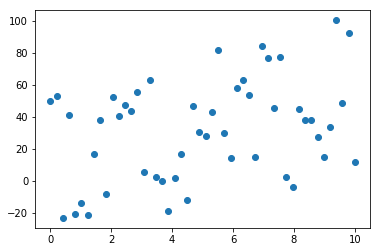

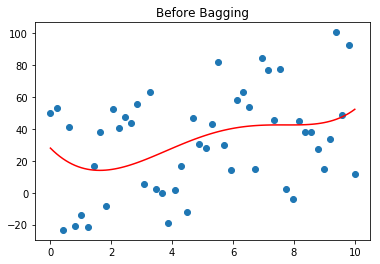

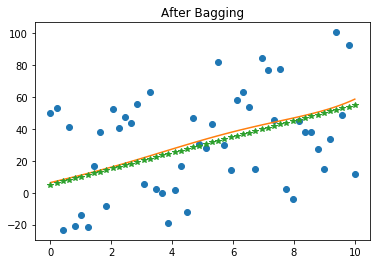

In [22]:
#Q4(a)
m=5
c=5
rn=10*np.random.uniform(-5,5,(50,))
x=np.linspace(0,10,50)
y=m*x+c+rn
plt.plot(x,y,'o')
plt.show()

#Q4(b)
p = np.poly1d(np.polyfit(x, y, 5))
t=np.linspace(0,10,100)
plt.plot(x,y,'o',t,p(t),'r')
plt.title('Before Bagging')
plt.show()

#Q4(c)
t=np.linspace(0,10,100)
n=100
s=np.array([0]*n)
for i in range(n):
    b=np.array(random.choices(x,k=50))
    y_b=m*b+c+rn
    p = np.poly1d(np.polyfit(b, y_b, 5))
    #plt.plot(t,p(t),'g')
    s=s+p(t)
s=s/n
plt.plot(x,y,'o',t,s)
plt.plot(x,m*x+c,'*')
plt.title('After Bagging')
plt.show()

# Q5

/Users/girish/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


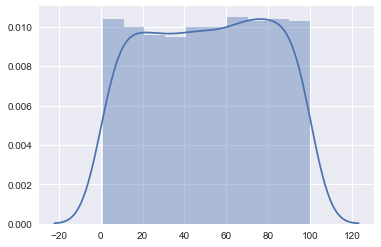

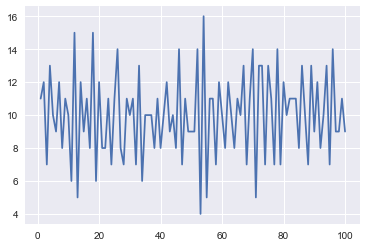

In [24]:
#Q5(a)
def random_me(l,n):
    #t=math.sin((time.time()-time.clock())*10)*10000000
    t=math.sin(time.time())*1000000
    return l[int(t%n)]

#Q5(b)
n=100
r=list(range(1,n+1))
out=np.array([0]*100)
ran=np.array([0]*1000)
for i in range(1000):
    ran[i]=random_me(r,n)
for v in ran:
    out[v-1]+=1
sns.set(color_codes=True)
sns.distplot(list(ran))
plt.show()
plt.plot(r,out)
plt.show()